# Challenge slot-filling
<hr style="border-width:2px;border-color:#A93226">

## Introduction

> 
The problem of this challenge is to determine the way a word has one meaning or another.
    For instance after "Are you ..." in my every-day conversations I can often find feelings such as "fine", "sad", "hungry"or "happy".
    Sometimes we hear a conversation and we miss a single word, then by knowing the words before and after (and frequently a noise that sounds like the missing word) we manage to reconstitute the whole sentence.
    I decide to make the algorithm on the same process. The algorithm looks one after the other words in the query and find a probability vectors for the different meanings by taking in account the words around.


- Create an alternative data base
- Data reshaping to increase the amount of data
- Data cleaning with nlp processes
- Analysis of the data base to avoid important stop words
- Probability model
- Error Analysis
- Conclusion and ideas to improve performance

## <span style="text-decoration : underline">Import packages and datas<span>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
from pprint import pprint
import nltk
nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS
import sys
print ('\n' + sys.version)
print("\n 3.6.2 (v3.6.2:5fd33b5926, Jul 16 2017, 20:11:06) \n [GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]")


3.6.3 (default, Oct  4 2017, 06:09:15) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.37)]

 3.6.2 (v3.6.2:5fd33b5926, Jul 16 2017, 20:11:06) 
 [GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


[nltk_data] Downloading package punkt to /Users/francois/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<hr style="border-width:2px;border-color:#A93226">

Choose the type of the query by changing the number bellow in the range [0,6]. <br>Examples in the conclusion are made for number = 0 ie 'AddToPlaylist' type of query.

In [12]:
number = 0
list_of_query_type = ['AddToPlaylist','GetWeather','SearchCreativeWork' , 'BookRestaurant','PlayMusic','RateBook' ,'SearchScreeningEvent']
type_of_query = list_of_query_type[number]

pre_data = json.load(open(type_of_query+'_queries.json'))
pre_data_test = json.load(open(type_of_query+'_test.json'))

In [13]:
#pprint(data_test)

## <span style="text-decoration : underline">Alternative data base<span>

Instead of having a small sentence that is refering to an entity, I choose to split this small sentence to associate each words of it to its entity.
As a consequence 'What will be the weather like' and 'Will the weather be like', because they have similar words, will increase the amount of data and avoid the case of a never-seen-before sentence

In [14]:
#Convertir les nombres écrits en nombre
def alternative_data_base(data):
    new_data = []
    for element in data[type_of_query]:
        for key,value in element.items():
            list_temp = []
            for dico in value:
                for word in dico['text'].split(' '):
                    unite_dico = {'text' : word}
                    if 'entity' in dico.keys():
                        unite_dico['entity'] = dico['entity']
                    else :
                        unite_dico['entity'] = 'None'
                    list_temp.append(unite_dico)
        new_data.append({'data' : list_temp})
    new_data = {type_of_query : new_data}
    return(new_data)

In [15]:
data = alternative_data_base(pre_data)
data_test = alternative_data_base(pre_data_test)

## <span style="text-decoration : underline">Data Cleaning <span>

I choose not to use the stop.words list in the library nltk because it removes important link words such as 'to' , 'in' ... that indicates to the algorithm the entities possible before and after.
A new type of query could be add, and the algorithm keeps working.

In [17]:
common_list = ['the','a','this','another','please','.','?',',','can','you','an','me',"I'd",'I','want','wanted','would','like'] 
dico_stop_words ={'AddToPlaylist' : common_list
                  , 'GetWeather' : common_list ,'RateBook':common_list, 'PlayMusic' :common_list, 
                  'PlayMusic' : common_list, 'SearchScreeningEvent': common_list}

## <span style="text-decoration : underline">Data reshaping<span>

In [18]:
def sum_text(vecteur_text):
    output = ''
    for word in vecteur_text:
        output = output +' '+ word
    return(output)

In [19]:
def data_reshape(data):
    ps = PorterStemmer()
    queries_entity = []
    future_df = []
    i = 0

    for element in data[type_of_query]:
        temp = ''
        temp_entity = []
        i+=1
        for value in element.values():
            for dico in value:
                temp_future = [i]
                temp += ps.stem(dico['text'])+' '
                temp_future.append(dico['text'].lower())
                if 'entity' in dico.keys():
                    temp_entity.append(dico['entity'])
                    temp_future.append(dico['entity'])
                else :
                    temp_future.append('None')
                if '' in temp_future:
                    temp_future.remove('')
                future_df.append(temp_future)
    
    df = pd.DataFrame(future_df, columns=['query_id','text','entity'])
    df.dropna(subset = ['text','entity'], inplace = True)
    
    #We remove here stop words specificaly for each type of query
    df = df[~df.text.isin(dico_stop_words[type_of_query])]
    
    queries = df.groupby('query_id').apply(lambda x : sum_text(x.text))
        
    return({'queries_entity': queries_entity,'df':df})

I create the data bases on which I train the algorithm and then test it. I decided to had the entity 'None' as a string to make a single type column and fill the empty entity variable of the words without "meaning" in the raw data base.

In [20]:
df = data_reshape(data)['df']
df_test = data_reshape(data_test)['df']

Here is the queries cleaned :

In [21]:
df.groupby('query_id').apply(lambda x : sum_text(x.text)).reset_index(name = 'query')

,query_id,query
0,1,add song to cita romántica playlist.
1,2,add clem burke in my playlist pre-party r&b jams
2,3,add live from aragon ballroom to trapeo
3,4,add unite and win to my night out
4,5,add track to my digster future hits
5,6,add piano bar to my cindy wilson
6,7,add spanish harlem incident to cleaning house
7,8,add greyest of blue skies in indie español my...
8,9,add name kids in street to plylist new indie mix
9,10,add album radar latino


I create a list of all entities. It is usefull to create the column of the training dataframe

In [22]:
all_queries_entity = df_test.entity.unique()
list(all_queries_entity)

['None', 'music_item', 'playlist_owner', 'playlist', 'entity_name', 'artist']

>By looking the data base, I can see that after the word "add", there are a lots of artist, entity or music_item.
I want to apply this argument to the whole data_base and put probability of presence.

$\text{add_col}$ is a function that iterate on row to see what entity is before for each text element of each query

In [23]:
def add_col(df):
    query_id = 0
    entity_before = ''
    entity_before_list = []
    for index, row in df.iterrows():
        if row.query_id == query_id :
            entity_before_list.append(entity_before)
        else :
            entity_before = ''
            entity_before_list.append(entity_before)
            query_id = row.query_id
        entity_before = row.entity
    return(entity_before_list)

To know for each row what is the entity of the word after, I inverse the index of the data frame and apply the same function.
Then reinverse the index.

In [24]:
df['entity_before'] = add_col(df)
df = df.iloc[::-1]
df['entity_after'] = add_col(df)
df = df.iloc[::-1]

## <span style="text-decoration : underline">Data base analysis<span>

Wordcloud is a very basic data visualization in nlp, and I should make a wordcloud that links the word between each others.

In [25]:
re.sub(' +',' ','The     quick brown    fox')

'The quick brown fox'

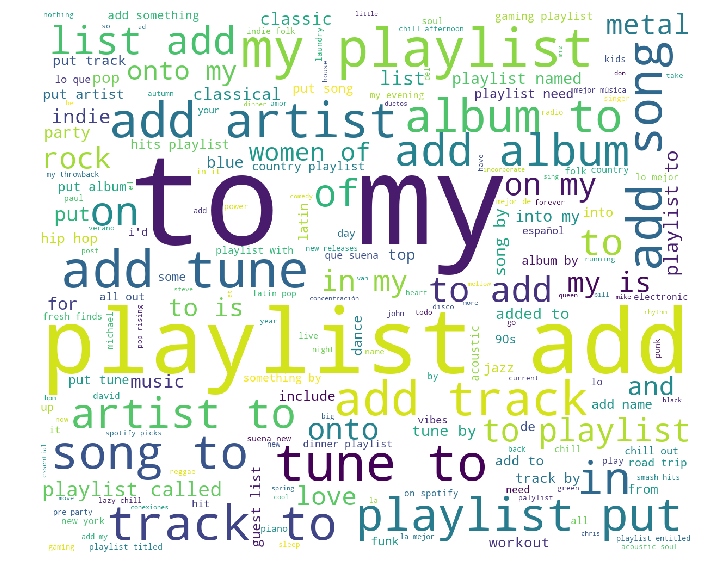

In [26]:
fig, ax = plt.subplots(figsize=(12,10))
wordcloud = WordCloud(
                          stopwords= [],
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(re.sub(' +',' ',sum_text(df.text)))   #remove multiple spaces in the strinf

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Here we can guess that the "word" is a wrong stop word for the GetWeather data base.<br>
In SearchScreeningEvent, the range of size of the words is small, we can guess the error will be bigger than for the others type of query.

## <span style="text-decoration : underline">Probability model<span> <br><br>

> 
Giving a $query = (word_1, word_2, ..., word_n)\text{ , } word_i \in \Omega_{word}$ and <br><br>$\Omega_{entity}$ the space of all possible entities for a given type of query.
>
Let : $$ word,query \mapsto meaning(word,query)$$ <br><br>be the function that give the entity of the word in the query.
The problem is to find :<br><br> $$entity = (meaning(word_i , query))_{i \in [1,n]}$$ which is a probabilitical function.<br><br>
Let's take a $i$ that is not the first neather the last word, I suppose that :<br><br> $$ \mathbb{P}[meaning(word_i,query) = entity_j |query] =  \mathbb{P}[meaning(word_i,query) = entity_j | entity_{i-1},word_{i},entity_{i+1}]$$<br>
>
In other words, I assume that the entity of a word in a query depends on itself but also on the entities of the word before and after him.
Then I calculate the table in which each row represents a word found in the training data base whom columns are a word : <br><br>$$ \forall word_{i} \in \Omega_i  \text{,  }\mathbb{P}[meaning(word_i,query) = entity_j |word_h] $$ <br>$$\forall h \in [i-1,i+1], \forall entity_j \in  \Omega_{entity}$$

>Because I assume that : $$\mathbb{P}[meaning(word_i,query) = entity_j | entity_{i-1},word_{i},entity_{i+1}]$$ has a linear relation with the above proababilities ie :  $$\exists \text{ }(\alpha_{i-1},\alpha_i,\alpha_{i+1}) \in \mathbb{R} ^3,$$ such as :
$$ \mathbb{P}[meaning(word_i,query) = entity_j | entity_{i-1},word_{i},entity_{i+1}] = $$
$$\sum_{h = i-1}^{i+1}{ \alpha_h \times \mathbb{P}[meaning(word_i,query)} = entity_j |word_h] $$

>I wheight the probability in the linear relation by the number of occurence  of $word_h$ in the test-base.<br><br>
Finally, I choose $entity_j$ that maximises the linear relation.

In [27]:
proba = df.groupby('text').apply(lambda x : pd.Series({
    **{'occurence_number': len(x)},
    
    **{'number_'+entity+'_before' : sum(x.entity_before == entity)/len(x) for entity in all_queries_entity },
                                                                                                          
    **{'number_'+entity+'_after' : sum(x.entity_after == entity)/len(x)  for entity in all_queries_entity  },
                                                                                                                 
    **{'number_'+entity : sum(x.entity == entity)/len(x) for entity in all_queries_entity },
                                                    }
                                                    )).reset_index()

$\text{text_to_proba}$ is a function that give a dictionary of probability, whose keys are all entity in $\Omega_{entity}$.

In [28]:
which_list = {'before': '_before' ,'after': '_after', 'itself' : ''}
def text_to_proba(text, which):
    
    proba_dict = { entity : [proba[proba.text == text]['number_'+entity+which_list[which]].iloc[0]  ,  int(proba[proba.text == text]['occurence_number'].iloc[0])] if len(proba[proba.text == text]) > 0 else [0,0] for entity in all_queries_entity }

    return(proba_dict )

$\text{multiply}$ is a function that a wheighted addition of the probabilities of the 3 dictionnaries. <br>
Parameters of the wheighted addition are : $$(\alpha,\beta,\gamma)$$<br>

In [29]:
def multiply(before,itself,after,alpha,beta,gamma):
    new_dic = {}
    list_keys = np.unique(list(before.keys()) + list(itself.keys()) + list(after.keys()))
    
    if before == {}:
        before = {clef : [0,0] for clef in before.keys()}
        
    if itself == {}:
        itself = {clef : [0,0] for clef in before.keys()}
        
    if after == {}:
        after = {clef : [0,0] for clef in before.keys()}
        
    for key in before.keys():
        sum_occurence = before[key][1] + itself[key][1] + after[key][1]
         
        if sum_occurence == 0: #I don't want to divide by zero line 22
            sum_occurence = 1
            
        new_dic[key] = (alpha * before[key][0] * before[key][1]  + beta*itself[key][0]*itself[key][1] + gamma*after[key][0]*after[key][1])/sum_occurence

    if list(max_value(itself).values())[0] >0.90:
        new_dic = max_value(itself)
        
    return(new_dic)

From a probability dictionnary, $\text{max_value}$  returns a dictionnary with the max value of the dictionnary and the key associated

In [30]:
def max_value(dico):
    max_value = 0
    max_key = 0
    for key,value in dico.items():
        if value[0] > max_value:
            max_value = value[0]
            max_key = key
    return({max_key : max_value})    

$\text{key_max_value}$ returns, given a dictionnary of probabilities, argmax of the keys

In [ ]:
def key_max_value(dico):
    max_value = 0
    max_key = ''
    for key, value in dico.items():
        if value > max_value:
            max_key = key
            max_value = value
    return(max_key)

Given a query, $\text{word_to_test}$ returns the entity of each words of the query, by taking the key of the max value in the probability dictionnary.

In [ ]:
def word_to_test_to_demo(query):
    word_tokens = query.split(' ')
    word_tokens = [word_token if word_token not in dico_stop_words[type_of_query] else 'None' for word_token in word_tokens]
   
    dict_output = {}
    for index,word in enumerate(word_tokens):
        if index == 0:
            output = key_max_value(  multiply(text_to_proba(word_tokens[index+1],'before'),text_to_proba(word,'itself'),{},alpha,beta,gamma))
        if index == len(word_tokens)-1:
            output = key_max_value(multiply( text_to_proba(word_tokens[index-1],'before')  ,text_to_proba(word,'itself'), {},alpha,beta,gamma ))
        elif (index >0) & (index < len(word_tokens)-1) :
            output = key_max_value(multiply(text_to_proba(word_tokens[index+1],'before'),text_to_proba(word,'itself'),text_to_proba(word_tokens[index-1],'after'),alpha,beta,gamma))

        dict_output[word] = output
   
    to_return = [{word : dict_output[word]} if word in dict_output.keys() else {word : 'None'} for word in query.split(' ')]

    return(to_return)

In [ ]:
def word_to_test(query):
    word_tokens = query
    vecteur = []
    vecteur_word = []
    
    for index,word in enumerate(word_tokens):
        if index == 0:
            output = key_max_value(  multiply(text_to_proba(word_tokens[index+1],'before'),text_to_proba(word,'itself'),{},alpha,beta,gamma))
        if index == len(word_tokens)-1:
            output = key_max_value(multiply( text_to_proba(word_tokens[index-1],'before')  ,text_to_proba(word,'itself'), {},alpha,beta,gamma ))
        elif (index >0) & (index < len(word_tokens)-1) :
            output = key_max_value(multiply(text_to_proba(word_tokens[index+1],'before'),text_to_proba(word,'itself'),text_to_proba(word_tokens[index-1],'after'),alpha,beta,gamma))
        vecteur_word.append(word)    
        vecteur.append(output)
        
    return([vecteur_word,vecteur])

Given the test data base and the wheighted parameters, $\text{df_predict_bis}$ returns the data frame with an extra prediction entity column.

In [ ]:
def df_predict_bis(df_test,alpha,beta,gamma):
    entity_test = []
    queries_df = df_test.groupby('query_id')

    for query_id, group in queries_df:
        entity_test += word_to_test(list(group.text))[1]

    df_test['entity_test'] = entity_test
    df_test['prediction'] = df_test.apply(lambda row : row.entity == row.entity_test,axis = 1)

    return(df_test)

$\text{df_predict}$ returns the metrics performance of the algorithm

In [ ]:
def df_predict(df_test,alpha,beta,gamma):
    entity_test = []
    queries_df = df_test.groupby('query_id')

    for query_id, group in queries_df:
        entity_test += word_to_test(list(group.text))[1]

    df_test['entity_test'] = entity_test
    df_test['prediction'] = df_test.apply(lambda row : row.entity == row.entity_test,axis = 1)
    grouped = df_test.groupby('query_id').apply(lambda x : 1 if sum(x.prediction)/len(x) ==1 else 0).reset_index(name = 'number')
    wrong_entity_rate = sum(grouped.number)/len(grouped)
    wrong_query_rate = sum(df_test.prediction)/len(df_test)
    
    vanity_metric = df_test.groupby('query_id').apply(lambda x : pd.Series({
    'query_type' : list(x[x.entity != 'None'].entity.unique()) ,
    'query_type_test' : list(x[x.entity_test != 'None'].entity_test.unique()) ,
    'query' : sum_text(x.text)
                                } )).reset_index()
    vanity_metric['prediction'] = vanity_metric.apply(lambda row : row.query_type == row.query_type_test , axis =1 )
    vanity_metric = sum(vanity_metric.prediction)/len(vanity_metric)

    return([wrong_entity_rate,wrong_query_rate,vanity_metric])

## <span style="text-decoration : underline">Error analysis<span>

The natural performance metric can be the percentage of query that is full right (every single word of the query has the right entity), I name its the entity metric. <br>
But it hides a lot of information, I  add another metric (the query metric) wich is the percentage of right entity in the data base of all query merged.<br>
Then if there is one entity mistake in each queries, entity_metric is 0 where as the query metric gives something close to 1 with a big data base.<br>
The last metric I chose is the vanity metricfor a given query : 1 if all the entity of the query = prediction(all the entity of the query). 

In [ ]:
alpha =1
beta =2
gamma = 0.2
    
temp = df_predict(df_test,alpha,beta,gamma)
entity_metric = temp[0]
query_metric = temp[1]
vanity_metric = temp[2]

In [ ]:
print('For the type of query '+type_of_query+" and for alpha, beta, gamma like above, the algorithm gets the following results :")
print('')
print('Entity metric = '+str(round(entity_metric,2)))
print('Query metric = '+str(round(query_metric ,2)))
print('Vanity metric = '+str(round(vanity_metric,2)))

## <span style="text-decoration : underline">Conclusion<span>

The algorithm performs very good on query where every entities is a single word like :

In [43]:
word_to_test_to_demo("I'd like to add Californication to the rock playlist")

[{"I'd": 'None'},
 {'like': 'None'},
 {'to': 'None'},
 {'add': 'None'},
 {'Californication': 'music_item'},
 {'to': 'None'},
 {'the': 'None'},
 {'rock': 'playlist'},
 {'playlist': 'None'}]

But fails when the entities are more than 3 words :

In [29]:
 word_to_test_to_demo("please can you add Also sprach Zarathustra to my cult movie soundtrack playlist")

[{'please': 'None'},
 {'can': 'None'},
 {'you': 'None'},
 {'add': 'None'},
 {'Also': 'music_item'},
 {'sprach': ''},
 {'Zarathoustra': 'music_item'},
 {'to': 'None'},
 {'my': 'playlist_owner'},
 {'cult': 'playlist'},
 {'movie': 'None'},
 {'soundtrack': 'playlist'},
 {'playlist': 'None'}]

The way to fix this kind of issue could be to calculate the probability of the output and compare with the probability of alternative outputs such as :

```python
[{'please': 'None'},
{'can': 'None'},
 {'you': 'None'},
 {'add': 'None'},
 {'Also': 'music_item'},
 {'sprach': 'music_item'},
 {'Zarathustra': 'music_item'},
 {'to': 'None'},
 {'my': 'playlist_owner'},
 {'cult': 'playlist'},
 {'movie': 'playlist'},
 {'songs': 'playlist'},
 {'playlist': 'None'}] ```

Or make the entity of a word depends on words further than one before and one after. In the previous query, for the word 'sprach', the algorithm would see 'add' two words before and 'to' two words after and conclude with 'music_item'.

>Some ideas to increase the performance : 
- Another way to increase the performance would have been to boost the parameters alpha, beta, gamma conditionally to the given word.
 The easiest way is to perform a linear regression of the probabilities in the Probabilities model part.
- Boost the parameters alpha, beta conditionally with the type_of_query.<br>
 In order to make the best boosting of the parameters, I would have merge the training base and test base and make cross-validations by    randomly choosing the test base and the training base. <br>It avoids over-fitting on the test base, and makes a more robust algorithm to change of data
- Change the number words in the query, <br>'Book a vegan restaurant at nine fifty in the afternoon' will give 'Book a vegan restaurant at 9 50 in the afternoon.' <br>Then add a regex that identifies number in the queries, 
- I noticed spelling mistakes in the data base such as 'plylist' and this remains to be fixed. But it could be very time costful to check for spelling mistake in the whole data base.
- Make an algorithm that first identify the type of the query by looking at the word in the query and comparing them to the data base of all queries merged and then deal with the query as done here.